# Recalibrate intrinsic/extrinsic parameters with both plate fiducials and guide bundles

### Dec. 11th, 2018

Here is the summary from the previous test:
- Most of the unrealistically large residue that we had before was due to my miscalculation of **Tc[3]** from **Tc[1-2]**. Now it is solved.
- Up to now, the best recalibration method by using the plate fiducials is the following:
 + First, calibrate **Tc[], Rc[3], fc, cc[]**
 + Then calibrate **Rc[1-2], kc[1]**
 + Then calibrate **kc[2-5]**
 + Go back to the first part and repeat until all parameters converge.
- The median $3\sigma$ residue from various trial is about 50 mpix, which roughly corresponds to 25 microns in the current 3-camera fiducial setting.
 + Most of the error may come from **kc[]**, which is barely constrained by using plate fiducials.
 + The above values may be okay since it is less than the total requirement (30 microns), but it would be good to check if there is a room for enhancement.

In this note, let's consider how we can improve it by adding the guide bundles.
While Michael suggested some special configurations of guide bundles to recalibrate certain parameters, let's assume an ordinary overall LSQ fitting again.

Then the questions are:
- By adding the guide bundles, which fitting method is best (e.g., will 3-round iteration still the best)?
- How many number guide bundles are required?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import interpolate as itpl

In [2]:
def ReadPlatePos(prefix):
    rawData = np.genfromtxt("../08_mod01_07_dataWithROCCorrection/%s.dat" % (prefix))
    arrPlt,arrPix = rawData[:,2:5],rawData[:,5:7]
    return arrPlt

In [3]:
class Parameter:
    def __init__(self):
        self.ROC = 3265.
        self.DFOV = 1200.
        self.fc = 7246.376812
        self.Tc = np.array([0,-299.408892,-3261.955597])
        self.Rc = np.array([0,0,0])	# Rotation in units of rad...
        self.kc = np.array([-0.2,0,0,0,0])		# radial distortion coefficients
        self.cc = np.array([1224,1025])
        
        
def GetFiducialParameter(prefix):
    params = Parameter()  # See Parameter::__init__ for the definition of other parameters
    params.Rc = np.array([0,0,0])	# Rotation in units of rad... see below
    
    if prefix == "MANIFEST_sim_001_coord_data_camera-1":
        params.Rc = np.array([0.097242,-0.097242,1.568608])
    elif prefix == "MANIFEST_sim_001_coord_data_camera-2":
        params.Rc = np.array([0.120983,0.032417,-0.522923])
    elif prefix == "MANIFEST_sim_001_coord_data_camera-3":
        params.Rc = np.array([0.043415,0.162026,-2.613643])
        
    return params

In [4]:
def ChangeFiducialParameter(params,valType,valPercent):
    if valPercent < -1 or valPercent > 1:
        print("Error: value error should be between -1% ~ +1%!!!")
        return params
    frac = 1.+valPercent*0.01
    
    newParams = Parameter()
    newParams.fc = params.fc
    newParams.Tc = np.copy(params.Tc)
    newParams.Rc = np.copy(params.Rc)
    newParams.kc = np.copy(params.kc)
    newParams.cc = np.copy(params.cc)
    
    if valType == "fc":
        newParams.fc *= frac
    elif valType[:2] == "Tc":
        TcTotSq = newParams.Tc[0]**2 + newParams.Tc[1]**2 + newParams.Tc[2]**2
        if valType[2] == '0':
            newParams.Tc[0] = 0.01*valPercent*newParams.Tc[1]
        else:
            newParams.Tc[1] *= frac
        newParams.Tc[2] = -np.sqrt(TcTotSq - newParams.Tc[0]**2 - newParams.Tc[1]**2)
    elif valType[:2] == "Rc":
        newParams.Rc[np.int(valType[2])] *= frac
    elif valType[:2] == "kc":
        if valType[2] == '0':
            newParams.kc[0] *= frac
        else:
            newParams.kc[np.int(valType[2])] = 1E-6*valPercent
    elif valType[:2] == "cc":
        newParams.cc[np.int(valType[2])] *= frac
    else:
        print("Error: type should be either (fc, Tc#, Rc#, kc#, cc#)")
    return newParams

In [5]:
def ConvertPlateToPix(arrPlate,params):
    
    cameraMatrix = np.array([[params.fc,0,params.cc[0]],[0,params.fc,params.cc[1]],[0,0,1]],dtype=np.float64)
    #print("Before cv2.projectPoints: Rc = ",params.Rc,params.Rc.dtype,flush=True)
    arrPix,jac = cv2.projectPoints(np.copy(arrPlate),np.array(params.Rc,dtype=np.float64),np.array(params.Tc,dtype=np.float64),cameraMatrix,params.kc)
    arrPix = arrPix.reshape(-1,2)
    
    return arrPix

"""
Returns two maps : (Xpix,Ypix) ---> (Xplt) and (Xpix,Ypix) ---> (Yplt)
from given plate alignment/camera distortion parameters and spline interpolation setup.

Input:
- params : Parameter() object that contains plate alignment/camera distortion parameters.
- kind : kind of spline interpolation ('linear','cubic','quintic')
- Ngrid : number of grids from -DFOV/2 to +DFOV/2

Output:
- mapXYpixToXplt : mapping function of (Xpix,Ypix) ---> (Xplt)
- mapXYpixToYplt : mapping function of (Xpix,Ypix) ---> (Yplt)
"""
def MakeMapPixToPlate(params,kind,Ngrid):
    
    """Step 1. Make the grid for X_plate and Y_plate"""
    Xplt,Yplt = np.mgrid[-params.DFOV*0.5:params.DFOV*0.5:Ngrid*1j,-params.DFOV*0.5:params.DFOV*0.5:Ngrid*1j]
    Xplt,Yplt = Xplt.flatten(),Yplt.flatten()
    #print("Dimension of Xplt : ",Xplt.shape)

    """Step 2. Calculate the Z_plate for each X_plate and Y_plate, and stack it"""
    Zplt = np.sqrt(params.ROC**2-Xplt**2-Yplt**2) - params.ROC
    XYZplt = np.vstack([Xplt,Yplt,Zplt]).T
    #print("Dimension of XYZplt : ",XYZplt.shape)

    """Step 3. Project 3D points to an image plane, by using OpenCV"""
    cameraMatrix = np.array([[params.fc,0,params.cc[0]],[0,params.fc,params.cc[1]],[0,0,1]])
    XYpix,Jacob = cv2.projectPoints(XYZplt,params.Rc,params.Tc,cameraMatrix,params.kc)
    XYpix = XYpix.reshape(-1,2)
    #print("Dimension of XYpix : ",XYpix.shape)

    """Step 4. Construct maps to find (Xpix,Ypix) ---> (Xplt) and (Xpix,Ypix) ---> (Yplt)"""
    mapXYpixToXplt = itpl.interp2d(XYpix[:,0],XYpix[:,1],Xplt,kind=kind)
    mapXYpixToYplt = itpl.interp2d(XYpix[:,0],XYpix[:,1],Yplt,kind=kind)

    return mapXYpixToXplt,mapXYpixToYplt

    
    
"""
Returns X/Y/Z plate position from a given X/Y camera position and mappin functions.

Input:
- arrPixPos : X/Y camera position in units of px.
- mapXYpixToXplt : mapping function of (Xpix,Ypix) ---> (Xplt)
- mapXYpixToYplt : mapping function of (Xpix,Ypix) ---> (Yplt)
- params : Parameter() object that contains plate alignment/camera distortion parameters.

Output:
	- XYZplt : X/Y/Z plate position in units of mm.
"""
def ConvertPixToPlate(arrPix,mapXYpixToXplt,mapXYpixToYplt,params):

    """Step 1. Get the Xplt and Yplt"""
    Xplt = np.array([mapXYpixToXplt(x,y) for x,y in arrPix]).flatten()
    Yplt = np.array([mapXYpixToYplt(x,y) for x,y in arrPix]).flatten()
    #print("Dimension of Xplt : ",Xplt.shape)

    """Step 2. Get the Zplt from Xplt and Yplt, and stack it"""
    Zplt = np.sqrt(params.ROC**2-Xplt**2-Yplt**2) - params.ROC
    XYZplt = np.vstack([Xplt,Yplt,Zplt]).T
    #print("Dimension of XYZplt : ",XYZplt.shape)

    return XYZplt

In [6]:
def MakePlateFiducial(N,radius,ROC):
    arrTheta = np.arange(N)*(2.*np.pi/N)
    arrX,arrY = radius*np.cos(arrTheta),radius*np.sin(arrTheta)
    arrZ = np.sqrt(ROC**2-arrX**2-arrY**2) - ROC
    
    return np.vstack([arrX,arrY,arrZ]).T

In [7]:
def CollectPixWithinFrame(arrOld,width,height):
    indx = (arrOld[:,0] >= 0) & (arrOld[:,0] < width) & (arrOld[:,1] >= 0) & (arrOld[:,1] < height)
    return arrOld[indx,:]

def GetFiducialSubset(arrPlate,arrPixFid,arrPixNew):
    arrPlateSub = []
    for pixNew in arrPixNew:
        diffSq = (arrPixFid[:,0]-pixNew[0])**2 + (arrPixFid[:,1]-pixNew[1])**2
        indx = np.argmin(diffSq)
        arrPlateSub.append(arrPlate[indx,:])
        
    return np.array(arrPlateSub)

In [8]:
def ChangeFullFiducialParameter(paramOrig,arrPercent):
    params = ChangeFiducialParameter(paramOrig,"Tc0",arrPercent[0])
    params = ChangeFiducialParameter(params,"Tc1",arrPercent[1])
    params = ChangeFiducialParameter(params,"Rc0",arrPercent[2])
    params = ChangeFiducialParameter(params,"Rc1",arrPercent[3])
    params = ChangeFiducialParameter(params,"Rc2",arrPercent[4])
    params = ChangeFiducialParameter(params,"fc",arrPercent[5])
    params = ChangeFiducialParameter(params,"kc0",arrPercent[6])
    params = ChangeFiducialParameter(params,"kc1",arrPercent[7])
    params = ChangeFiducialParameter(params,"kc2",arrPercent[8])
    params = ChangeFiducialParameter(params,"kc3",arrPercent[9])
    params = ChangeFiducialParameter(params,"kc4",arrPercent[10])
    params = ChangeFiducialParameter(params,"cc0",arrPercent[11])
    params = ChangeFiducialParameter(params,"cc1",arrPercent[12])
    
    return params

In [9]:
def MakeGuideBundle(N,radius,ROC):
    arrRand = np.random.rand(N,2)
    arrR,arrTheta = radius*np.sqrt(arrRand[:,0]),2.*np.pi*arrRand[:,1]
    arrX,arrY = arrR*np.cos(arrTheta),arrR*np.sin(arrTheta)
    arrZ = np.sqrt(ROC**2 - arrX**2 - arrY**2) - ROC
    
    return np.vstack([arrX,arrY,arrZ]).T

In [10]:
def TestFitting(filename,Nguide):

    WIDTH,HEIGHT = 2448,2050

    # Get the fiducial choice for camera 1
    prefix = "MANIFEST_sim_001_coord_data_camera-1"
    params = GetFiducialParameter(prefix)
    plateTarget = ReadPlatePos(prefix)
    plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
    pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

    plateGB = MakeGuideBundle(Nguide,params.DFOV*0.5,params.ROC)
    pixGBFid = ConvertPlateToPix(plateGB,params)

    plt.clf()
    fig,axs = plt.subplots(2,5,figsize=(20,8))
    axs = axs.flatten()

    # Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
    Nvar = 100
    randVar = np.random.rand(Nvar,13)*2-1.

    arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
    arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

    errBudget = []
    for rv,ivar in zip(randVar,range(1,Nvar+1)):
        newParams = ChangeFullFiducialParameter(params,rv)
        pixTarget = ConvertPlateToPix(plateTarget,newParams)
        pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        pixGB = ConvertPlateToPix(plateGB,newParams)
        
        pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
        plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
        
        pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
        plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
        
        """
        print("pixFiducialSub: ",pixFiducialSub.shape," pixGBSub: ",pixGBSub.shape,flush=True)
        print("vstack(pixFiducialSub,pixGBSub): ",np.vstack([pixFiducialSub,pixGBSub]).shape)
        return
        """
        plateSub = np.vstack([plateFiducialSub,plateGBSub])
        pixSub = np.vstack([pixFiducialSub,pixGBSub])
        
        estParams = RecalibrateParameter(plateSub,pixSub,params)
        arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
        arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
        arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
        arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
        arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
        arrFcE.append((estParams.fc-params.fc)/params.fc*100)
        arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
        arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
        arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

        estPixTarget = ConvertPlateToPix(plateTarget,estParams)
        residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
        errBudget.append(np.percentile(residues,99.865))
        print("\r","Done sample %3d" % (ivar),end='',flush=True)

    for ax,orig,est,valType in zip(axs[:-1],
                                   [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                                   [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                                   ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
        ax.scatter(orig,est,s=1,rasterized=True)
        ax.set_title(valType)
        ax.set_xlabel("Original error [%]")
        ax.set_ylabel("Estimated error [%]")
    
    axs[-1].hist(errBudget,bins=np.logspace(1,4,21))
    axs[-1].set_xlabel("3-sigma Residue [mpix]")
    axs[-1].set_xscale("log")
    axs[-1].set_ylabel("Frequency")
    plt.savefig("output/%s" % (filename),bbox_inches="tight",dpi=150)

## A. Extrinsic -> Intrinsic
### 1. No iteration

In [11]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize two types of parameters:
    # - extrinsic = [Tc[0],Tc[1],Rc[0],Rc[1],Rc[2]]
    # - intrinsic = [fc,kc[0],kc[1],kc[2],kc[3],kc[4],cc[0],cc[1]]
    extFid = np.concatenate([paramsFid.Tc[:2],paramsFid.Rc])
    intFid = np.concatenate([np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc])
    
    extLP,extHP = extFid*0.99,extFid*1.01
    intLP,intHP = intFid*0.99,intFid*1.01
    
    extLB = np.minimum(extLP,extHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    extUB = np.maximum(extLP,extHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    intLB = np.minimum(intLP,intHP) + np.array([0,0,-1E-6,-1E-6,-1E-6,-1E-6,0,0])
    intUB = np.maximum(intLP,intHP) + np.array([0,0,1E-6,1E-6,1E-6,1E-6,0,0])
    
    # 2. Calibrate extrinsic --> intrinsic
    # Here, calibrate at once.
    extrinsic = opt.least_squares(ResidueChangeExtrinsic,extFid,
                                  args=(arrPlate,arrPix,intFid),bounds=(extLB,extUB),
                                  ftol=1E-16,xtol=1E-16).x
    intrinsic = opt.least_squares(ResidueChangeIntrinsic,intFid,
                                  args=(arrPlate,arrPix,extrinsic),bounds=(intLB,intUB),
                                  ftol=1E-16,xtol=1E-16).x

    newParam = ConstructParameter(extrinsic,intrinsic)
    return newParam

def ConstructParameter(extrinsic,intrinsic):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([extrinsic[0],extrinsic[1],-np.sqrt(TcSq - extrinsic[0]**2 - extrinsic[1]**2)])
    params.Rc = np.copy(extrinsic[2:])
    params.fc = intrinsic[0]
    params.kc = np.copy(intrinsic[1:6])
    params.cc = np.copy(intrinsic[6:])
    return params

def ResidueChangeExtrinsic(extrinsic,arrPlate,arrPix,intrinsic):
    params = ConstructParameter(extrinsic,intrinsic)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeIntrinsic(intrinsic,arrPlate,arrPix,extrinsic):
    params = ConstructParameter(extrinsic,intrinsic)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 Done sample 100

<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

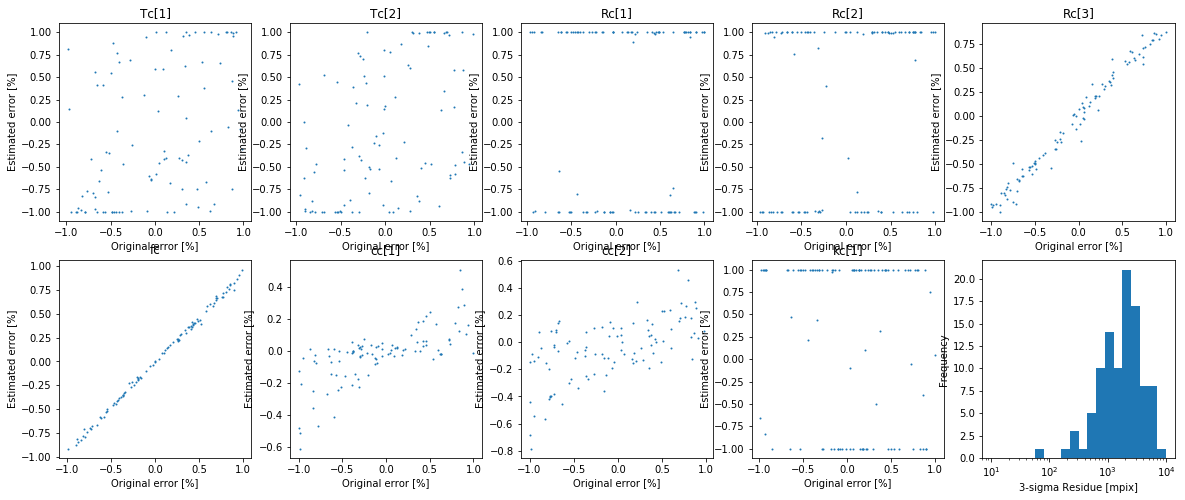

In [21]:
TestFitting("extrinsic_noIter_1e1.pdf",10)
TestFitting("extrinsic_noIter_3e1.pdf",30)
TestFitting("extrinsic_noIter_1e2.pdf",100)
TestFitting("extrinsic_noIter_3e2.pdf",300)

### 2. With iteration

In [12]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize two types of parameters:
    # - extrinsic = [Tc[0],Tc[1],Rc[0],Rc[1],Rc[2]]
    # - intrinsic = [fc,kc[0],kc[1],kc[2],kc[3],kc[4],cc[0],cc[1]]
    extFid = np.concatenate([paramsFid.Tc[:2],paramsFid.Rc])
    intFid = np.concatenate([np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc])
    
    extLP,extHP = extFid*0.99,extFid*1.01
    intLP,intHP = intFid*0.99,intFid*1.01
    
    extLB = np.minimum(extLP,extHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    extUB = np.maximum(extLP,extHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    intLB = np.minimum(intLP,intHP) + np.array([0,0,-1E-6,-1E-6,-1E-6,-1E-6,0,0])
    intUB = np.maximum(intLP,intHP) + np.array([0,0,1E-6,1E-6,1E-6,1E-6,0,0])
    
    # 2. Calibrate extrinsic --> intrinsic by repeating
    extrinsic,intrinsic = np.copy(extFid),np.copy(intFid)
    for iteration in range(100):
        extOld,intOld = np.copy(extrinsic),np.copy(intrinsic)
        
        extrinsic = opt.least_squares(ResidueChangeExtrinsic,extOld,
                                      args=(arrPlate,arrPix,intOld),bounds=(extLB,extUB),
                                      ftol=1E-16,xtol=1E-16).x
        intrinsic = opt.least_squares(ResidueChangeIntrinsic,intOld,
                                      args=(arrPlate,arrPix,extrinsic),bounds=(intLB,intUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((extrinsic-extOld)/extOld)),np.amax(np.abs((intrinsic-intOld)/intOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(extrinsic,intrinsic)
    return newParam

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


 Done sample 100

<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

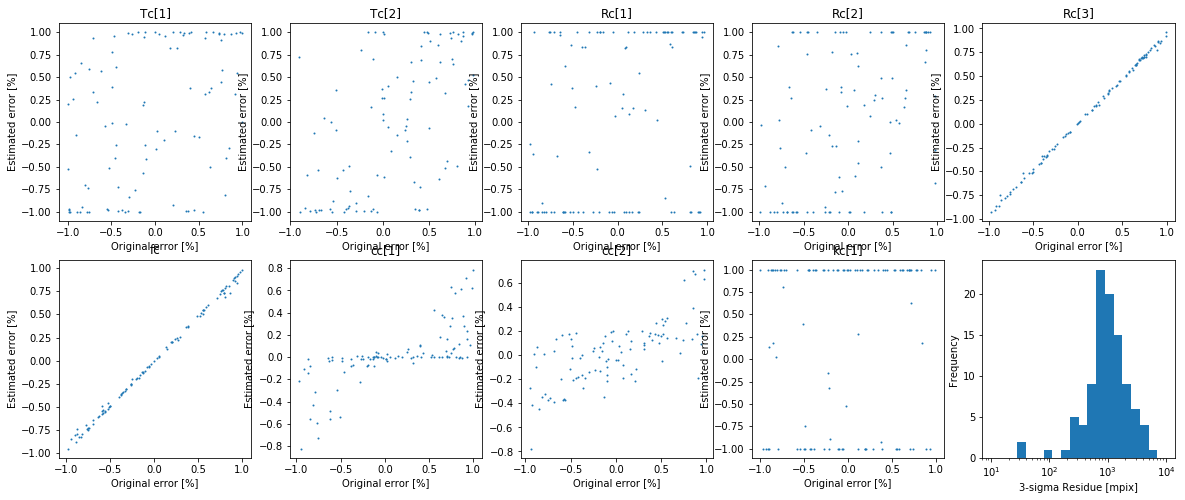

In [14]:
#TestFitting("extrinsic_iter_1e1.pdf",10)
TestFitting("extrinsic_iter_3e1.pdf",30)
TestFitting("extrinsic_iter_1e2.pdf",100)
TestFitting("extrinsic_iter_3e2.pdf",300)

## B. Intrinsic -> Extrinsic
### 1. No iteration

In [15]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize two types of parameters:
    # - extrinsic = [Tc[0],Tc[1],Rc[0],Rc[1],Rc[2]]
    # - intrinsic = [fc,kc[0],kc[1],kc[2],kc[3],kc[4],cc[0],cc[1]]
    extFid = np.concatenate([paramsFid.Tc[:2],paramsFid.Rc])
    intFid = np.concatenate([np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc])
    
    extLP,extHP = extFid*0.99,extFid*1.01
    intLP,intHP = intFid*0.99,intFid*1.01
    
    extLB = np.minimum(extLP,extHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    extUB = np.maximum(extLP,extHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    intLB = np.minimum(intLP,intHP) + np.array([0,0,-1E-6,-1E-6,-1E-6,-1E-6,0,0])
    intUB = np.maximum(intLP,intHP) + np.array([0,0,1E-6,1E-6,1E-6,1E-6,0,0])
    
    # 2. Calibrate intrinsic --> extrinsic
    # Here, calibrate at once.
    intrinsic = opt.least_squares(ResidueChangeIntrinsic,intFid,
                                  args=(arrPlate,arrPix,extFid),bounds=(intLB,intUB),
                                  ftol=1E-16,xtol=1E-16).x
    extrinsic = opt.least_squares(ResidueChangeExtrinsic,extFid,
                                  args=(arrPlate,arrPix,intrinsic),bounds=(extLB,extUB),
                                  ftol=1E-16,xtol=1E-16).x

    newParam = ConstructParameter(extrinsic,intrinsic)
    return newParam

 Done sample 100

<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

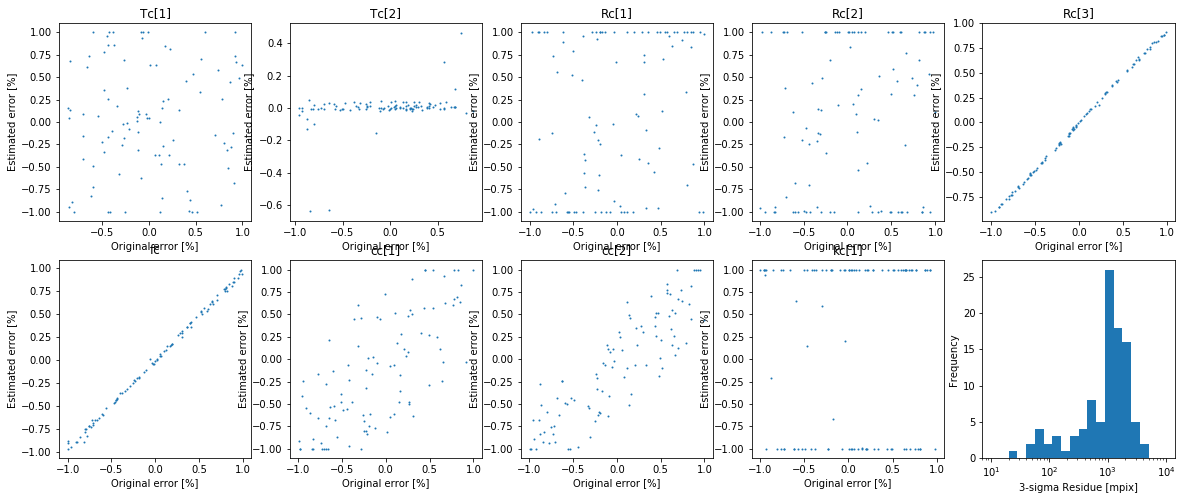

In [16]:
TestFitting("intrinsic_noIter_1e1.pdf",10)
TestFitting("intrinsic_noIter_3e1.pdf",30)
TestFitting("intrinsic_noIter_1e2.pdf",100)
TestFitting("intrinsic_noIter_3e2.pdf",300)

### 2. With iteration

In [17]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize two types of parameters:
    # - extrinsic = [Tc[0],Tc[1],Rc[0],Rc[1],Rc[2]]
    # - intrinsic = [fc,kc[0],kc[1],kc[2],kc[3],kc[4],cc[0],cc[1]]
    extFid = np.concatenate([paramsFid.Tc[:2],paramsFid.Rc])
    intFid = np.concatenate([np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc])
    
    extLP,extHP = extFid*0.99,extFid*1.01
    intLP,intHP = intFid*0.99,intFid*1.01
    
    extLB = np.minimum(extLP,extHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    extUB = np.maximum(extLP,extHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    intLB = np.minimum(intLP,intHP) + np.array([0,0,-1E-6,-1E-6,-1E-6,-1E-6,0,0])
    intUB = np.maximum(intLP,intHP) + np.array([0,0,1E-6,1E-6,1E-6,1E-6,0,0])
    
    # 2. Calibrate intrinsic --> extrinsic by repeating
    extrinsic,intrinsic = np.copy(extFid),np.copy(intFid)
    for iteration in range(100):
        extOld,intOld = np.copy(extrinsic),np.copy(intrinsic)
        
        intrinsic = opt.least_squares(ResidueChangeIntrinsic,intOld,
                                      args=(arrPlate,arrPix,extOld),bounds=(intLB,intUB),
                                      ftol=1E-16,xtol=1E-16).x
        extrinsic = opt.least_squares(ResidueChangeExtrinsic,extOld,
                                      args=(arrPlate,arrPix,intrinsic),bounds=(extLB,extUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((extrinsic-extOld)/extOld)),np.amax(np.abs((intrinsic-intOld)/intOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(extrinsic,intrinsic)
    return newParam

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


 Done sample 100

<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

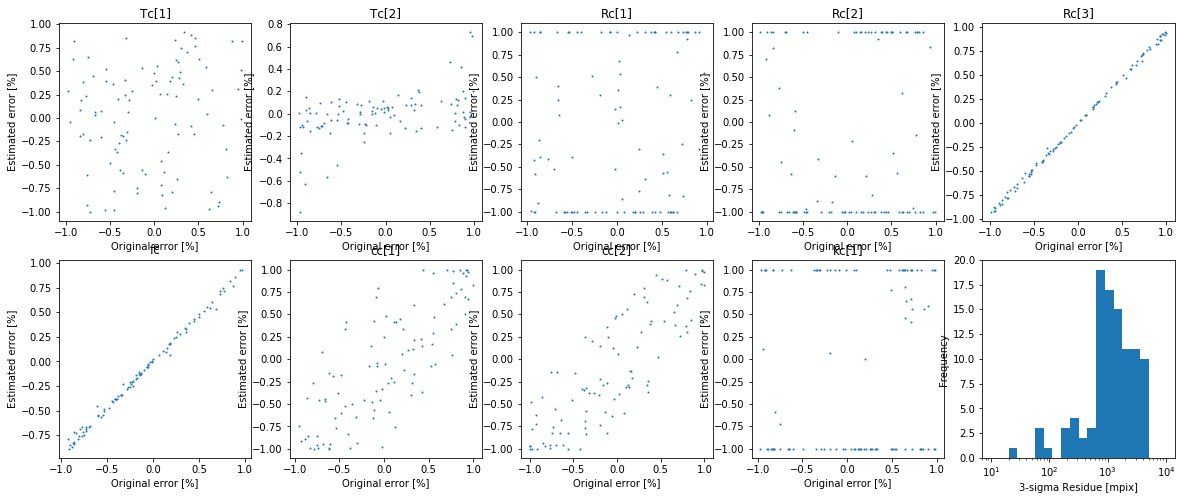

In [18]:
TestFitting("intrinsic_iter_1e1.pdf",10)
TestFitting("intrinsic_iter_3e1.pdf",30)
TestFitting("intrinsic_iter_1e2.pdf",100)
TestFitting("intrinsic_iter_3e2.pdf",300)

## C. **Tc[], Rc[3], fc, cc[]** --> **Rc[1-2], kc[1]** --> **kc[2-5]** 
### 1. No iteration

In [13]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalParam = [Tc[0],Tc[1],Rc[2],fc,cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    critical = np.array([paramsFid.Tc[0],paramsFid.Tc[1],paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    probable = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundant = np.copy(paramsFid.kc[1:])
        
    criticalLP,criticalHP = critical*0.99,critical*1.01
    probableLP,probableHP = probable*0.99,probable*1.01
    
    criticalLB = np.minimum(criticalLP,criticalHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    criticalUB = np.maximum(criticalLP,criticalHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalParam --> probableParam --> redundantParam
    # Here, calibrate at once.
    critical = opt.least_squares(ResidueChangeCritical,critical,
                                 args=(arrPlate,arrPix,probable,redundant),
                                 bounds=(criticalLB,criticalUB),ftol=1E-16,xtol=1E-16).x
    probable = opt.least_squares(ResidueChangeProbable,probable,
                                 args=(arrPlate,arrPix,critical,redundant),
                                 bounds=(probableLB,probableUB),
                                    ftol=1E-16,xtol=1E-16).x
    redundant = opt.least_squares(ResidueChangeRedundant,redundant,
                                     args=(arrPlate,arrPix,critical,probable),
                                     bounds=(redundantLB,redundantUB),
                                     ftol=1E-16,xtol=1E-16).x

    newParam = ConstructParameter(critical,probable,redundant)
    return newParam


def ConstructParameter(criticalParam,probableParam,redundantParam):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalParam[0],criticalParam[1],-np.sqrt(TcSq - criticalParam[0]**2 - criticalParam[1]**2)])
    params.Rc = np.array([probableParam[0],probableParam[1],criticalParam[2]])
    params.fc = criticalParam[3]
    params.kc = np.array([probableParam[2],redundantParam[0],redundantParam[1],redundantParam[2],redundantParam[3]])
    params.cc = np.array([criticalParam[4],criticalParam[5]])
    return params

def ResidueChangeCritical(criticalParam,arrPlate,arrPix,probableParam,redundantParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeProbable(probableParam,arrPlate,arrPix,criticalParam,redundantParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeRedundant(redundantParam,arrPlate,arrPix,criticalParam,probableParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


NameError: name 'probableLowBound' is not defined

<Figure size 432x288 with 0 Axes>

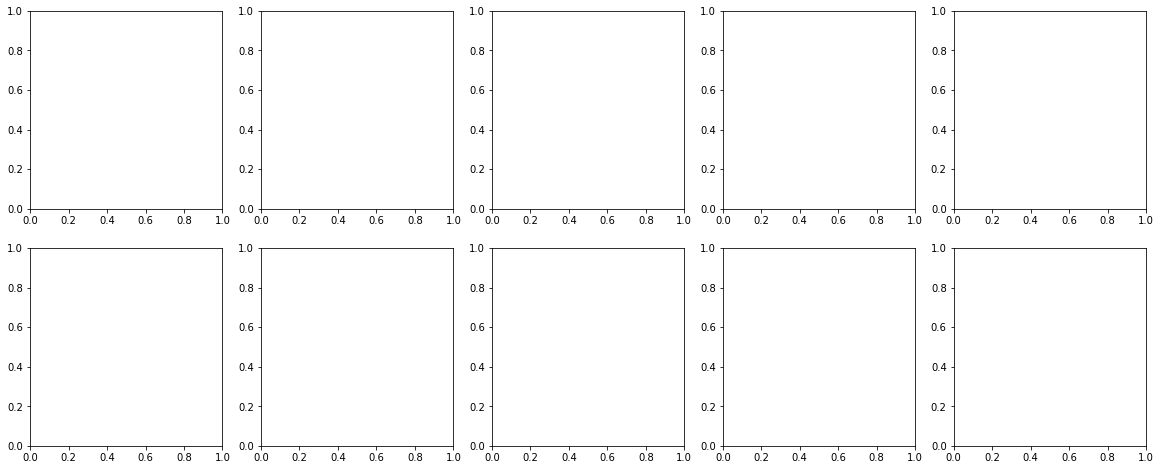

In [20]:
TestFitting("3step_noIter_1e1.pdf",10)
TestFitting("3step_noIter_3e1.pdf",30)
TestFitting("3step_noIter_1e2.pdf",100)
TestFitting("3step_noIter_3e2.pdf",300)

### 2. With iteration

In [14]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalParam = [Tc[0],Tc[1],Rc[2],fc,cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalFid = np.array([paramsFid.Tc[0],paramsFid.Tc[1],paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    probableFid = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundantFid = np.copy(paramsFid.kc[1:])
        
    criticalLP,criticalHP = criticalFid*0.99,criticalFid*1.01
    probableLP,probableHP = probableFid*0.99,probableFid*1.01
    
    criticalLB = np.minimum(criticalLP,criticalHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    criticalUB = np.maximum(criticalLP,criticalHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalParam --> probableParam --> redundantParam
    # Here, calibrate multiple times
    critical,probable,redundant = np.copy(criticalFid),np.copy(probableFid),np.copy(redundantFid)
    for iteration in range(100):
        criticalOld,probableOld,redundantOld = np.copy(critical),np.copy(probable),np.copy(redundant)
        critical = opt.least_squares(ResidueChangeCritical,criticalOld,
                                     args=(arrPlate,arrPix,probableOld,redundantOld),
                                     bounds=(criticalLB,criticalUB),
                                     ftol=1E-16,xtol=1E-16).x
        probable = opt.least_squares(ResidueChangeProbable,probableOld,
                                     args=(arrPlate,arrPix,critical,redundantOld),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
        redundant = opt.least_squares(ResidueChangeRedundant,redundantOld,
                                      args=(arrPlate,arrPix,critical,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((critical-criticalOld)/criticalOld)),
                  np.amax(np.abs((probable-probableOld)/probableOld)),
                  np.amax(np.abs((redundant-redundantOld)/redundantOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(critical,probable,redundant)
    return newParam

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


 Done sample 100

<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

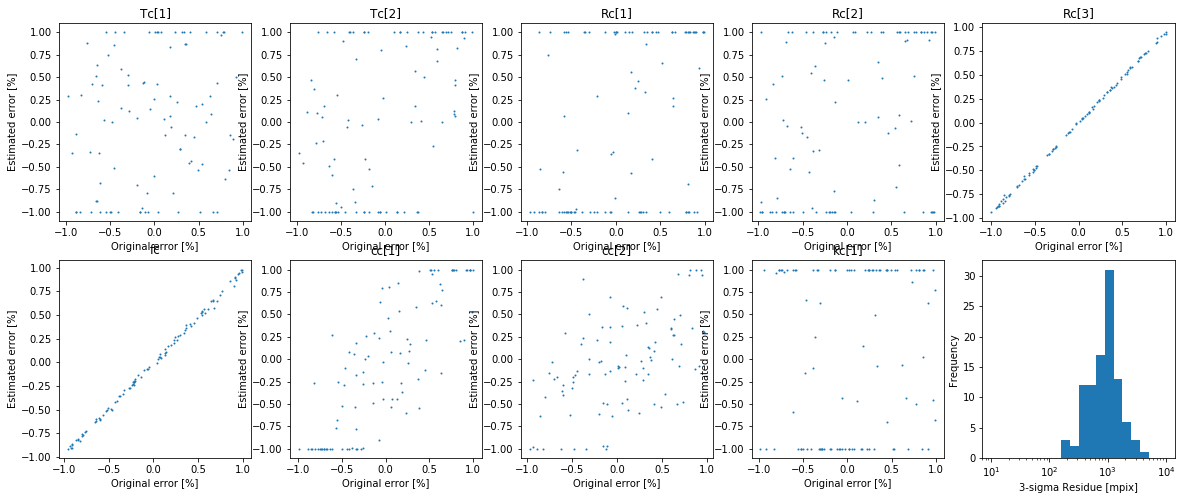

In [15]:
#TestFitting("3step_iter_1e1.pdf",10)
TestFitting("3step_iter_3e1.pdf",30)
TestFitting("3step_iter_1e2.pdf",100)
TestFitting("3step_iter_3e2.pdf",300)

## D. **Rc[3], fc** --> **Tc[], cc[]** --> **Rc[1-2], kc[1]** --> **kc[2-5]** 
### 1. No iteration

In [16]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalAParam = [Rc[2],fc]
    # - criticalBParam = [Tc[0],Tc[1],cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalA = np.array([paramsFid.Rc[2],paramsFid.fc],dtype=np.float64)
    criticalB = np.concatenate([paramsFid.Tc[:2],paramsFid.cc])
    probable = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundant = np.copy(paramsFid.kc[1:])
        
    criticalALP,criticalAHP = criticalA*0.99,criticalA*1.01
    criticalBLP,criticalBHP = criticalB*0.99,criticalB*1.01
    probableLP,probableHP = probable*0.99,probable*1.01
    
    criticalALB,criticalAUB = np.minimum(criticalALP,criticalAHP),np.maximum(criticalALP,criticalAHP)
    criticalBLB = np.minimum(criticalBLP,criticalBHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.],dtype=np.float64)
    criticalBUB = np.maximum(criticalBLP,criticalBHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalAParam --> criticalBParam --> probableParam --> redundantParam
    # Here, calibrate at once
    criticalA = opt.least_squares(ResidueChangeCriticalA,criticalA,
                                     args=(arrPlate,arrPix,criticalB,probable,redundant),
                                     bounds=(criticalALB,criticalAUB),
                                     ftol=1E-16,xtol=1E-16).x
    criticalB = opt.least_squares(ResidueChangeCriticalB,criticalB,
                                     args=(arrPlate,arrPix,criticalA,probable,redundant),
                                     bounds=(criticalBLB,criticalBUB),
                                     ftol=1E-16,xtol=1E-16).x
    probable = opt.least_squares(ResidueChangeProbable,probable,
                                     args=(arrPlate,arrPix,criticalA,criticalB,redundant),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
    redundant = opt.least_squares(ResidueChangeRedundant,redundant,
                                      args=(arrPlate,arrPix,criticalA,criticalB,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
    newParam = ConstructParameter(criticalA,criticalB,probable,redundant)
    return newParam


def ConstructParameter(criticalA,criticalB,probable,redundant):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalB[0],criticalB[1],-np.sqrt(TcSq - criticalB[0]**2 - criticalB[1]**2)])
    params.Rc = np.array([probable[0],probable[1],criticalA[0]])
    params.fc = criticalA[1]
    params.kc = np.array([probable[2],redundant[0],redundant[1],redundant[2],redundant[3]])
    params.cc = np.array([criticalB[2],criticalB[3]])
    return params

def ResidueChangeCriticalA(criticalA,arrPlate,arrPix,criticalB,probable,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeCriticalB(criticalB,arrPlate,arrPix,criticalA,probable,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeProbable(probable,arrPlate,arrPix,criticalA,criticalB,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeRedundant(redundant,arrPlate,arrPix,criticalA,criticalB,probable):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 Done sample 100

<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

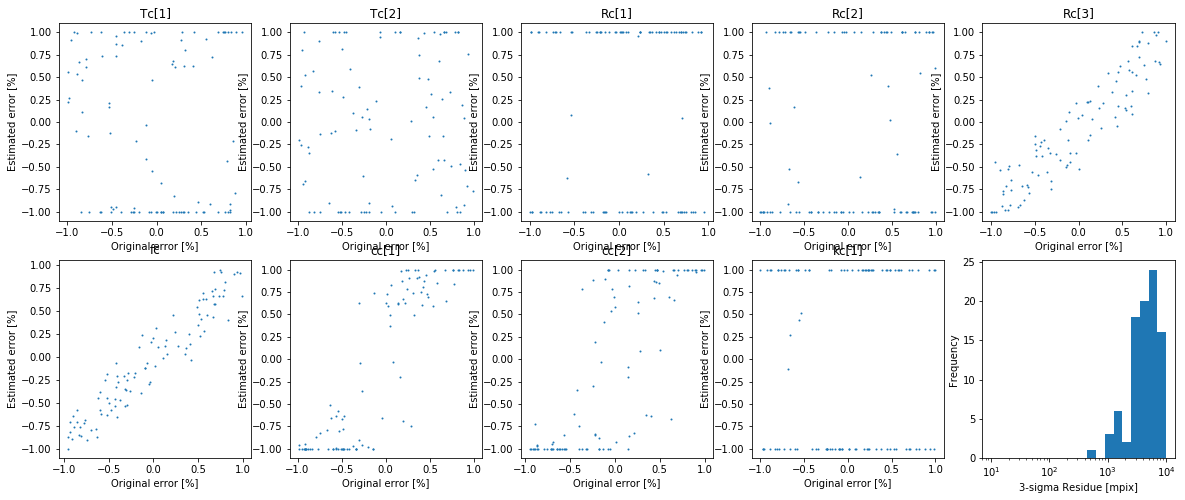

In [17]:
TestFitting("4step_noIter_1e1.pdf",10)
TestFitting("4step_noIter_3e1.pdf",30)
TestFitting("4step_noIter_1e2.pdf",100)
TestFitting("4step_noIter_3e2.pdf",300)

### 2. With iteration

In [18]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalAParam = [Rc[2],fc]
    # - criticalBParam = [Tc[0],Tc[1],cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalA = np.array([paramsFid.Rc[2],paramsFid.fc],dtype=np.float64)
    criticalB = np.concatenate([paramsFid.Tc[:2],paramsFid.cc])
    probable = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundant = np.copy(paramsFid.kc[1:])
        
    criticalALP,criticalAHP = criticalA*0.99,criticalA*1.01
    criticalBLP,criticalBHP = criticalB*0.99,criticalB*1.01
    probableLP,probableHP = probable*0.99,probable*1.01
    
    criticalALB,criticalAUB = np.minimum(criticalALP,criticalAHP),np.maximum(criticalALP,criticalAHP)
    criticalBLB = np.minimum(criticalBLP,criticalBHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.],dtype=np.float64)
    criticalBUB = np.maximum(criticalBLP,criticalBHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalAParam --> criticalBParam --> probableParam --> redundantParam
    # Here, calibrate multiple times
    for iteration in range(100):
        criticalAOld,criticalBOld,probableOld,redundantOld = np.copy(criticalA),np.copy(criticalB),np.copy(probable),np.copy(redundant)
        criticalA = opt.least_squares(ResidueChangeCriticalA,criticalAOld,
                                     args=(arrPlate,arrPix,criticalBOld,probableOld,redundantOld),
                                     bounds=(criticalALB,criticalAUB),
                                     ftol=1E-16,xtol=1E-16).x
        criticalB = opt.least_squares(ResidueChangeCriticalB,criticalBOld,
                                     args=(arrPlate,arrPix,criticalA,probableOld,redundantOld),
                                     bounds=(criticalBLB,criticalBUB),
                                     ftol=1E-16,xtol=1E-16).x
        probable = opt.least_squares(ResidueChangeProbable,probableOld,
                                     args=(arrPlate,arrPix,criticalA,criticalB,redundantOld),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
        redundant = opt.least_squares(ResidueChangeRedundant,redundantOld,
                                      args=(arrPlate,arrPix,criticalA,criticalB,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((criticalA-criticalAOld)/criticalAOld)),
                  np.amax(np.abs((criticalB-criticalBOld)/criticalBOld)),
                  np.amax(np.abs((probable-probableOld)/probableOld)),
                  np.amax(np.abs((redundant-redundantOld)/redundantOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(criticalA,criticalB,probable,redundant)
    return newParam

In [ ]:
TestFitting("4step_iter_1e1.pdf",10)
TestFitting("4step_iter_3e1.pdf",30)
TestFitting("4step_iter_1e2.pdf",100)
TestFitting("4step_iter_3e2.pdf",300)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide


 Done sample  39

## E. **Rc[3], fc, cc[]** --> **Tc[]** --> **Rc[1-2], kc[1]** --> **kc[2-5]** 
### 1. No iteration

In [ ]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalAParam = [Rc[2],fc,cc[0],cc[1]]
    # - criticalBParam = [Tc[0],Tc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalA = np.array([paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    criticalB = np.copy(paramsFid.Tc[:2])
    probable = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundant = np.copy(paramsFid.kc[1:])
        
    criticalALP,criticalAHP = criticalA*0.99,criticalA*1.01
    criticalBLP,criticalBHP = criticalB*0.99,criticalB*1.01
    probableLP,probableHP = probable*0.99,probable*1.01
    
    criticalALB,criticalAUB = np.minimum(criticalALP,criticalAHP),np.maximum(criticalALP,criticalAHP)
    criticalBLB = np.minimum(criticalBLP,criticalBHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.],dtype=np.float64)
    criticalBUB = np.maximum(criticalBLP,criticalBHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalAParam --> criticalBParam --> probableParam --> redundantParam
    # Here, calibrate at once
    criticalA = opt.least_squares(ResidueChangeCriticalA,criticalA,
                                     args=(arrPlate,arrPix,criticalB,probable,redundant),
                                     bounds=(criticalALB,criticalAUB),
                                     ftol=1E-16,xtol=1E-16).x
    criticalB = opt.least_squares(ResidueChangeCriticalB,criticalB,
                                     args=(arrPlate,arrPix,criticalA,probable,redundant),
                                     bounds=(criticalBLB,criticalBUB),
                                     ftol=1E-16,xtol=1E-16).x
    probable = opt.least_squares(ResidueChangeProbable,probable,
                                     args=(arrPlate,arrPix,criticalA,criticalB,redundant),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
    redundant = opt.least_squares(ResidueChangeRedundant,redundant,
                                      args=(arrPlate,arrPix,criticalA,criticalB,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
    newParam = ConstructParameter(criticalA,criticalB,probable,redundant)
    return newParam


def ConstructParameter(criticalA,criticalB,probable,redundant):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalB[0],criticalB[1],-np.sqrt(TcSq - criticalB[0]**2 - criticalB[1]**2)])
    params.Rc = np.array([probable[0],probable[1],criticalA[0]])
    params.fc = criticalA[1]
    params.kc = np.array([probable[2],redundant[0],redundant[1],redundant[2],redundant[3]])
    params.cc = np.array([criticalA[2],criticalA[3]])
    return params

In [ ]:
TestFitting("4step2_noIter_1e1.pdf",10)
TestFitting("4step2_noIter_3e1.pdf",30)
TestFitting("4step2_noIter_1e2.pdf",100)
TestFitting("4step2_noIter_3e2.pdf",300)

### 2. With iteration

In [ ]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalAParam = [Rc[2],fc,cc[0],cc[1]]
    # - criticalBParam = [Tc[0],Tc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalA = np.array([paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    criticalB = np.copy(paramsFid.Tc[:2])
    probable = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundant = np.copy(paramsFid.kc[1:])
        
    criticalALP,criticalAHP = criticalA*0.99,criticalA*1.01
    criticalBLP,criticalBHP = criticalB*0.99,criticalB*1.01
    probableLP,probableHP = probable*0.99,probable*1.01
    
    criticalALB,criticalAUB = np.minimum(criticalALP,criticalAHP),np.maximum(criticalALP,criticalAHP)
    criticalBLB = np.minimum(criticalBLP,criticalBHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.],dtype=np.float64)
    criticalBUB = np.maximum(criticalBLP,criticalBHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalAParam --> criticalBParam --> probableParam --> redundantParam
    # Here, calibrate multiple times
    for iteration in range(100):
        criticalAOld,criticalBOld,probableOld,redundantOld = np.copy(criticalA),np.copy(criticalB),np.copy(probable),np.copy(redundant)
        criticalA = opt.least_squares(ResidueChangeCriticalA,criticalAOld,
                                     args=(arrPlate,arrPix,criticalBOld,probableOld,redundantOld),
                                     bounds=(criticalALB,criticalAUB),
                                     ftol=1E-16,xtol=1E-16).x
        criticalB = opt.least_squares(ResidueChangeCriticalB,criticalBOld,
                                     args=(arrPlate,arrPix,criticalA,probableOld,redundantOld),
                                     bounds=(criticalBLB,criticalBUB),
                                     ftol=1E-16,xtol=1E-16).x
        probable = opt.least_squares(ResidueChangeProbable,probableOld,
                                     args=(arrPlate,arrPix,criticalA,criticalB,redundantOld),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
        redundant = opt.least_squares(ResidueChangeRedundant,redundantOld,
                                      args=(arrPlate,arrPix,criticalA,criticalB,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((criticalA-criticalAOld)/criticalAOld)),
                  np.amax(np.abs((criticalB-criticalBOld)/criticalBOld)),
                  np.amax(np.abs((probable-probableOld)/probableOld)),
                  np.amax(np.abs((redundant-redundantOld)/redundantOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(criticalA,criticalB,probable,redundant)
    return newParam

In [ ]:
TestFitting("4step2_iter_1e1.pdf",10)
TestFitting("4step2_iter_3e1.pdf",30)
TestFitting("4step2_iter_1e2.pdf",100)
TestFitting("4step2_iter_3e2.pdf",300)